In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

from itertools import product
import pandas as pd
import torch
import torch.nn.functional as F
from torch_sparse.tensor import SparseTensor
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

from src.train.gcn_node_classifier import GCNNodeClassifierTrainer
from src.torch_geo_models import GCN
from src.data.node_classifier.arxiv import load_dataset_pyg,\
    data_to_sparse_symmetric_pyg, get_edge_weights_pyg

### Read metrics

In [8]:
metrics = GCNNodeClassifierTrainer.read_metrics()
print(metrics.shape)
metrics.head()

(8381, 10)


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
0,1,0,False,1,3.754721,3.737225,3.727600,0.032494,0.037954,0.038640
1,1,50,False,1,3.205070,3.247568,3.271204,0.168604,0.092251,0.082526
2,1,100,False,1,2.997951,3.041117,3.073672,0.209718,0.150374,0.131165
3,1,150,False,1,2.862897,2.917441,2.958255,0.249722,0.230847,0.211839
4,1,200,False,1,2.749364,2.816427,2.865221,0.278598,0.279204,0.258688


## Selected model results

For each configuration we select a model based on the validation accuracy and compare on the test nodes.

In [9]:
def get_best_metrics(keys_df: pd.DataFrame):
    return keys_df.sort_values('acc_val', ascending=False).iloc[0]

best_epoch_metrics = metrics\
    .groupby(['run', 'n_layers', 'has_edge_weights'])\
    .apply(get_best_metrics)\
    .reset_index(drop=True)

print(best_epoch_metrics.shape)
print(best_epoch_metrics['run'].max())
best_epoch_metrics.tail()

(102, 10)
13


,run,epoch,has_edge_weights,n_layers,loss_train,loss_val,loss_test,acc_train,acc_val,acc_test
97,13,9700,True,1,1.115919,1.134110,1.181481,0.670809,0.662472,0.646133
98,13,2200,False,2,0.657311,0.898855,0.937827,0.790897,0.724857,0.712117
99,13,2200,True,2,0.661943,0.903274,0.937309,0.788874,0.723078,0.713392
100,13,1750,False,3,0.575364,0.859023,0.902914,0.808711,0.732273,0.718433
101,13,1600,True,3,0.591137,0.860652,0.899082,0.806402,0.733515,0.718886


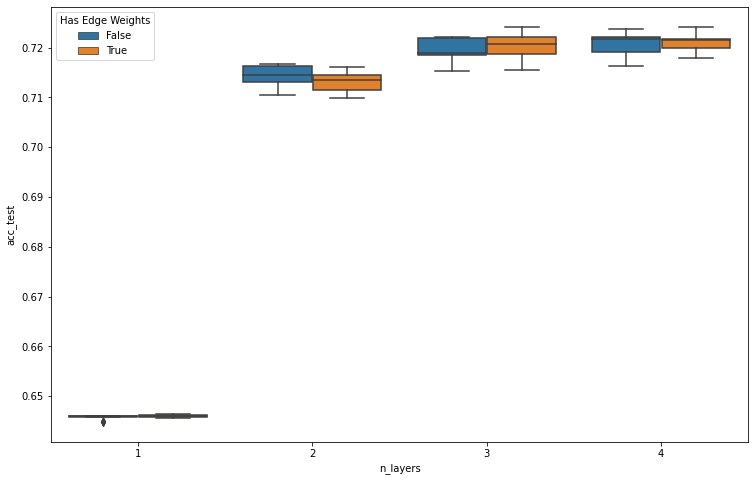

In [10]:
plt.figure(figsize=(12.5, 8))
sns.boxplot(
    data=best_epoch_metrics,
    x='n_layers',
    y='acc_test',
    hue='has_edge_weights')


# plt.yscale('log')
plt.legend(title='Has Edge Weights')

## T-test

In [11]:
for n_layers in range(1, 5):
    a = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == True')\
        ['acc_test']
        
    b = best_epoch_metrics\
        .query(f'n_layers == {n_layers} & has_edge_weights == False')\
        ['acc_test']
    ttest = ttest_ind(a, b)
    print(f'with: {a.mean():.4} +- {a.std():.4}, '
          f'no: {b.mean():.4} +- {b.std():.4}, '
          f't: {ttest.statistic:.4}, pvalue: {ttest.pvalue:.4}')

with: 0.646 +- 0.0002322, no: 0.6457 +- 0.0004837, t: 1.744, pvalue: 0.09393
with: 0.7132 +- 0.001835, no: 0.7143 +- 0.002146, t: -1.457, pvalue: 0.1581
with: 0.7202 +- 0.002732, no: 0.7196 +- 0.002059, t: 0.6957, pvalue: 0.4933
with: 0.721 +- 0.001893, no: 0.7208 +- 0.002434, t: 0.2504, pvalue: 0.8046


## Epochs comparison

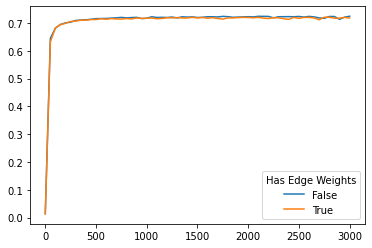

In [7]:
n_layers = 2
col = 'acc_val'

sub_df = metrics.query(f'n_layers == {n_layers}')

no_means = sub_df\
    .query('has_edge_weights == False')\
    .groupby('epoch')\
    [col]\
    .mean()

w_means = sub_df\
    .query('has_edge_weights == True')\
    .groupby('epoch')\
    [col]\
    .mean()

plt.plot(no_means, label='False')
plt.plot(w_means, label='True')

plt.legend(title='Has Edge Weights')
# plt.yscale('log')
# plt.xlim(200)
# plt.ylim(0.65, 0.75)